In [1]:
!conda list

# packages in environment at C:\Users\d8\miniconda3\envs\boost:
#
# Name                    Version                   Build  Channel
anyio                     3.6.2              pyhd8ed1ab_0    conda-forge
argon2-cffi               21.3.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0           py38h294d835_2    conda-forge
asttokens                 2.2.1              pyhd8ed1ab_0    conda-forge
attrs                     22.2.0             pyh71513ae_0    conda-forge
babel                     2.11.0             pyhd8ed1ab_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                pyhd8ed1ab_3    conda-forge
backports.functools_lru_cache 1.6.4              pyhd8ed1ab_0    conda-forge
beautifulsoup4            4.11.1             pyha770c72_0    conda-forge
blas                      1.0                         mkl  
bleach                    5.0.1              pyhd8ed1ab_0    conda-forge


In [2]:
# remove preprocessed data
#unix
#!rm -rf data/processed
#windows
#!rd /s /q "ABSOLUTE_PATH_TO\data-quality-abalone\data\processed"

In [3]:
from datetime import datetime

In [4]:
dt_start = datetime.utcnow()
print(dt_start)

2023-01-10 15:39:45.915241


In [5]:
import pandas as pd

In [6]:
import os
import sys
from pathlib import Path
from textwrap import dedent

In [7]:
STARS = 10 * '*'

In [8]:
## AS IT IS NOTEBOOK - we will show dataframes, not just print in logs

def show_full_dataframe(df: pd.DataFrame):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
        display(df)


def df_to_print(df: pd.DataFrame, name=None, nrows=3):
    print(f'{name}:')
    print(f'head({nrows}):')
    show_full_dataframe(df.head(nrows))
    print(f'tail({nrows}):')
    show_full_dataframe(df.tail(nrows))
    print(f'shape: {df.shape}')
    return ''

In [9]:
def _check_contents(path: Path, exts: list):
    """
    Check if folder contains files with extensions from exts list
    """
    exists_files = []
    for ext in exts:
        exists_files += list(path.rglob(f'*.{ext}'))

    if len(exists_files) > 0:
        pq_files_str = os.linesep + os.linesep.join(['\t' + str(f) for f in sorted(exists_files)]) + os.linesep
        raise ValueError(dedent(f"""
        Folder {path} already contains {exts} files:{pq_files_str}
        Saving in same folder can cause reading problems. Please, remove them or choose another folder.
        """))


def _log_size(name: str, df: pd.DataFrame):
    sz = sys.getsizeof(df) / 1024 ** 3
    print(f'size in GB: {sz}')
    print(df_to_print(df, name.upper()))


def parquet_save(output_folder_path: str, df: pd.DataFrame):
    output_folder_path = Path(output_folder_path)
    name = output_folder_path.name
    print(f'{STARS} SAVE TO PARQUET {name.upper()} {STARS}')
    _log_size(name, df)
    output_folder_path.mkdir(parents=True, exist_ok=True)
    _check_contents(output_folder_path, ['parquet'])
    save_path = output_folder_path / f'{name}.parquet'
    df.to_parquet(save_path)
    print(f'saved {name} to {save_path}')

In [10]:
def read_abalone(input_path: str, output_path: str):
    """
    Given is the attribute name, attribute type, the measurement unit and a
       brief description.  The number of rings is the value to predict: either
       as a continuous value or as a classification problem.

	Name		Data Type	Meas.	Description
	----		---------	-----	-----------
	Sex		nominal			M, F, and I (infant)
	Length		continuous	mm	Longest shell measurement
	Diameter	continuous	mm	perpendicular to length
	Height		continuous	mm	with meat in shell
	Whole weight	continuous	grams	whole abalone
	Shucked weight	continuous	grams	weight of meat
	Viscera weight	continuous	grams	gut weight (after bleeding)
	Shell weight	continuous	grams	after being dried
	Rings		integer			+1.5 gives the age in years

   Statistics for numeric domains:

		Length	Diam	Height	Whole	Shucked	Viscera	Shell	Rings
	Min	0.075	0.055	0.000	0.002	0.001	0.001	0.002	    1
	Max	0.815	0.650	1.130	2.826	1.488	0.760	1.005	   29
	Mean	0.524	0.408	0.140	0.829	0.359	0.181	0.239	9.934
	SD	0.120	0.099	0.042	0.490	0.222	0.110	0.139	3.224
	Correl	0.557	0.575	0.557	0.540	0.421	0.504	0.628	  1.0
    """
    col_names = [
        'Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 
        'Viscera weight', 'Shell weight', 'Rings'
    ]
    print(f'initial column names: {col_names}')
    col_names = ['_'.join(c.lower().split(' ')) for c in col_names]
    print(f'lowercase columns and replace space with underscore: {col_names}')
    dfs = []
    for p in Path(input_path).glob('*.csv'):
        print(f'reading: {str(p)}')
        dfs.append(pd.read_csv(
            p, sep=',', encoding='utf-8', names=col_names, 
            dtype = {
                'sex':               'str',
                'length':            'float',
                'diameter':          'float',
                'height':            'float',
                'whole_weight':      'float',
                'shucked_weight':    'float',
                'viscera_weight':    'float',
                'shell_weight':      'float',
                'rings':             'int'
            }
        ))

    parquet_save(output_path, pd.concat(dfs))

# I deliberately messed up one of the entries with an invalid value

In [11]:
# M,0.565,0.425,0.135,0.8115,0.341,0.1675,0.255,15
# whole_weight 0.8115 -> 100.0
# M,0.565,0.425,0.135,100.0,0.341,0.1675,0.255,15
# it has row index near to 90

In [12]:
SOURCE_DATA_PATH = Path('./data/source/')
PROCESSED_PATH = Path('./data/processed/')

In [13]:
abalone_path = PROCESSED_PATH / 'abalone'

In [14]:
read_abalone(SOURCE_DATA_PATH, abalone_path)

initial column names: ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
lowercase columns and replace space with underscore: ['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings']
reading: data\source\abalone.csv
********** SAVE TO PARQUET ABALONE **********
size in GB: 0.00045916996896266937
ABALONE:
head(3):


,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.21,9


tail(3):


,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.308,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.296,10
4176,M,0.710,0.555,0.195,1.9485,0.9455,0.3765,0.495,12


shape: (4177, 9)

saved abalone to data\processed\abalone\abalone.parquet


# make job step by step
## then we will combine them

In [15]:
abalone = pd.read_parquet(abalone_path)
abalone.dtypes

sex                object
length            float64
diameter          float64
height            float64
whole_weight      float64
shucked_weight    float64
viscera_weight    float64
shell_weight      float64
rings               int32
dtype: object

In [16]:
# just for example create boolean and int2str columns
abalone['diameter_bool'] = abalone['diameter'] > 0.5 
abalone['rings_str'] = abalone['rings'].astype(str)

In [17]:
import numpy as np

In [18]:
regression_cols = abalone.select_dtypes(include=np.number).columns
classification_cols = abalone.columns.difference(regression_cols)
print(f'classification_cols: {classification_cols}')
print(f'regression_cols: {regression_cols}')

print('if column wrongly marked as regression - cast it to string type before saving to parquet')

classification_cols: Index(['diameter_bool', 'rings_str', 'sex'], dtype='object')
regression_cols: Index(['length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
       'viscera_weight', 'shell_weight', 'rings'],
      dtype='object')
if column wrongly marked as regression - cast it to string type before saving to parquet


In [19]:
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import StratifiedKFold

In [20]:
from sklearn.preprocessing import LabelBinarizer
from scipy.special import xlogy

In [21]:
# copied and modified version of 
# https://github.com/scikit-learn/scikit-learn/blob/98cf537f5/sklearn/metrics/_classification.py#L2509
# which returns cross-entropy of each sample (without mean or sum)
def log_loss(y_true, y_pred, *, eps="auto", labels=None):
    eps = np.finfo(y_pred.dtype).eps if eps == "auto" else eps
    lb = LabelBinarizer()
    lb.fit(y_true)

    transformed_labels = lb.transform(y_true)

    if transformed_labels.shape[1] == 1:
        transformed_labels = np.append(
            1 - transformed_labels, transformed_labels, axis=1
        )

    # Clipping
    y_pred = np.clip(y_pred, eps, 1 - eps)

    # If y_pred is of single dimension, assume y_true to be binary
    # and then check.
    if y_pred.ndim == 1:
        y_pred = y_pred[:, np.newaxis]
    if y_pred.shape[1] == 1:
        y_pred = np.append(1 - y_pred, y_pred, axis=1)
        
    # Renormalize
    y_pred_sum = y_pred.sum(axis=1)
    y_pred = y_pred / y_pred_sum[:, np.newaxis]
    loss = -xlogy(transformed_labels, y_pred).sum(axis=1)
    return loss

In [22]:
k_folds = 5
reg_quantiles = 20

In [23]:
small_classes = {}
data_quality = {}
for c in abalone.columns:
    print(c)
    data_quality[c] = []
    # make a copy and ensure unique numeric index
    df = abalone.reset_index(drop=True)
    if c in regression_cols:
        # transform regression task to classification of quantile range
        df[c] = pd.qcut(df[c], reg_quantiles, duplicates='drop').astype(str)
        
    classes = df[c].value_counts().to_frame('counts')
    
    # rare labels (less than k_folds * 2 = 10 entries) automaticaly goes to outliers
    too_few_samples = classes[classes['counts'] < k_folds * 2]
    if too_few_samples.shape[0]:
        small_classes[c] = df.loc[df[c].isin(too_few_samples.index), c]
        df = df.drop(small_classes[c].index)
        classes = classes.drop(too_few_samples.index)
    
    if classes.shape[0] < 2: # constant value
        continue
    elif classes.shape[0] > 2: 
        multiclass = True
    else:
        multiclass = False
        
    loss = "MultiClass" if multiclass else "Logloss"
    params = {
        "verbose": False, 
        "od_wait": 5, # number of sequential iterations of not improved loss on validation set before training stops
        "use_best_model": True, 
        "auto_class_weights": 'Balanced',
        "loss_function": loss,
        "eval_metric": 'TotalF1:average=Weighted'
    }
    # print(params)
    
    # for simplicity encode class labels to integers
    classes['label'] = list(range(classes.shape[0]))
    print(classes)
    labels = df[[c]].copy()
    labels['int_label'] = labels[c].apply(lambda x: classes.loc[x, 'label'])
    inv_classes = classes.reset_index().set_index('label')
    
    skf = StratifiedKFold(n_splits=k_folds, random_state=0, shuffle=True)
    for i, (train_index, val_test_index) in enumerate(skf.split(np.zeros(df.shape[0]), labels[c])):
        train_dataset = Pool(
            data=df.drop(c, axis='columns').iloc[train_index],
            label=labels['int_label'].iloc[train_index],
            cat_features=classification_cols.drop(c, errors='ignore').to_list()
        )
        # make validation and test from val_test_index
        skf2 = StratifiedKFold(n_splits=2, random_state=0, shuffle=True)
        for val_index, test_index in skf2.split(np.zeros(val_test_index.shape[0]), labels[c].iloc[val_test_index]):
            val_dataset = Pool(
                data=df.drop(c, axis='columns').iloc[val_test_index[val_index]],
                label=labels['int_label'].iloc[val_test_index[val_index]],
                cat_features=classification_cols.drop(c, errors='ignore').to_list()
            )
            test_dataset = Pool(
                data=df.drop(c, axis='columns').iloc[val_test_index[test_index]],
                label=labels['int_label'].iloc[val_test_index[test_index]],
                cat_features=classification_cols.drop(c, errors='ignore').to_list()
            )
            clf = CatBoostClassifier(**params)
            clf.fit(train_dataset, eval_set=val_dataset)
            
            true_label = df[c].iloc[val_test_index[test_index]]
            pred_label = inv_classes.loc[np.array(clf.predict(test_dataset)).flatten(), 'index']
            cross_entropy = log_loss(
                labels['int_label'].iloc[val_test_index[test_index]], 
                clf.predict_proba(test_dataset)
            )
            preds = pd.DataFrame(
                index=df.index[val_test_index[test_index]],
                data=np.vstack((true_label, pred_label, cross_entropy)).T,
                columns=['true_label', 'pred_label', 'cross_entropy']
            )
            data_quality[c].append(preds)
    data_quality[c] = pd.concat(data_quality[c])


sex
   counts  label
M    1528      0
I    1342      1
F    1307      2
length
                counts  label
(0.625, 0.645]     269      0
(0.56, 0.575]      237      1
(0.525, 0.545]     232      2
(0.49, 0.51]       225      3
(0.585, 0.6]       224      4
(0.074, 0.295]     214      5
(0.295, 0.355]     214      6
(0.425, 0.45]      214      7
(0.39, 0.425]      213      8
(0.355, 0.39]      212      9
(0.545, 0.56]      210     10
(0.51, 0.525]      208     11
(0.69, 0.815]      207     12
(0.6, 0.615]       205     13
(0.47, 0.49]       202     14
(0.45, 0.47]       200     15
(0.615, 0.625]     181     16
(0.66, 0.69]       179     17
(0.645, 0.66]      175     18
(0.575, 0.585]     156     19
diameter
                counts  label
(0.435, 0.45]      284      0
(0.325, 0.35]      253      1
(0.395, 0.41]      245      2
(0.265, 0.3]       243      3
(0.48, 0.495]      232      4
(0.41, 0.425]      224      5
(0.054, 0.22]      219      6
(0.365, 0.38]      212      7
(0.522, 0.54

## anomaly detection

In [24]:
### combination of Robust and MinMax scalers
from scaling import scale_data

In [25]:
for c, cross_entropy in data_quality.items():
    scaled_loss, _, _ = scale_data(
        cross_entropy[['cross_entropy']], 
        test_df=None,
        quantile_range=(0,90)   # 90+ - highest loss values, small loss is OK, so left border is 0
    )
    cross_entropy['scaled_loss'] = scaled_loss['cross_entropy']
    cross_entropy.columns = [f'{c}|{dq_c}' for dq_c in cross_entropy.columns]
data_quality_df = pd.concat(data_quality.values(), axis=1).sort_index()
data_quality_df

,sex|true_label,sex|pred_label,sex|cross_entropy,sex|scaled_loss,length|true_label,length|pred_label,length|cross_entropy,length|scaled_loss,diameter|true_label,diameter|pred_label,...,rings|cross_entropy,rings|scaled_loss,diameter_bool|true_label,diameter_bool|pred_label,diameter_bool|cross_entropy,diameter_bool|scaled_loss,rings_str|true_label,rings_str|pred_label,rings_str|cross_entropy,rings_str|scaled_loss
0,M,F,1.103805,0.098835,"(0.45, 0.47]","(0.45, 0.47]",1.478942,-0.095176,"(0.35, 0.365]","(0.35, 0.365]",...,0.756691,0.099332,0.0,0.0,0.547566,-0.001373,15,15,1.212018,-0.136535
1,M,I,1.402583,0.414553,"(0.295, 0.355]","(0.355, 0.39]",1.515301,-0.07796,"(0.22, 0.265]","(0.265, 0.3]",...,0.657382,-0.020438,0.0,0.0,0.568565,0.155991,7,7,1.558946,0.092082
2,F,I,1.257913,0.261681,"(0.525, 0.545]","(0.525, 0.545]",1.508623,-0.081122,"(0.41, 0.425]","(0.395, 0.41]",...,1.074609,0.482753,0.0,0.0,0.554074,0.047397,9,9,1.407349,-0.007817
3,M,F,1.136375,0.133252,"(0.425, 0.45]","(0.47, 0.49]",2.325816,0.305797,"(0.35, 0.365]","(0.325, 0.35]",...,0.520728,-0.185247,0.0,0.0,0.576678,0.216787,10,9,1.844681,0.280374
4,I,I,0.630047,-0.401784,"(0.295, 0.355]","(0.295, 0.355]",0.58877,-0.516648,"(0.22, 0.265]","(0.22, 0.265]",...,0.657382,-0.020438,0.0,0.0,0.449319,-0.737631,7,7,1.337493,-0.05385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4172,F,F,0.981478,-0.030428,"(0.56, 0.575]","(0.575, 0.585]",1.877444,0.093505,"(0.435, 0.45]","(0.435, 0.45]",...,0.57198,-0.123435,0.0,0.0,0.554074,0.047397,11,11,1.34548,-0.048587
4173,M,F,1.078709,0.072316,"(0.585, 0.6]","(0.56, 0.575]",2.358598,0.321318,"(0.435, 0.45]","(0.45, 0.46]",...,1.167819,0.595168,0.0,0.0,0.448749,-0.741904,10,10,1.891114,0.310973
4174,M,F,0.986824,-0.024779,"(0.585, 0.6]","(0.6, 0.615]",2.01651,0.159349,"(0.47, 0.48]","(0.47, 0.48]",...,0.417781,-0.309404,0.0,0.0,0.568311,0.154089,9,9,0.88049,-0.355004
4175,F,F,0.99061,-0.020778,"(0.615, 0.625]","(0.615, 0.625]",1.467439,-0.100622,"(0.48, 0.495]","(0.47, 0.48]",...,1.167819,0.595168,0.0,0.0,0.575456,0.207633,10,10,1.383233,-0.023708


In [26]:
scaled_loss = data_quality_df[[c for c in data_quality_df.columns if 'scaled_loss' in c]].copy()
scaled_loss

,sex|scaled_loss,length|scaled_loss,diameter|scaled_loss,height|scaled_loss,whole_weight|scaled_loss,shucked_weight|scaled_loss,viscera_weight|scaled_loss,shell_weight|scaled_loss,rings|scaled_loss,diameter_bool|scaled_loss,rings_str|scaled_loss
0,0.098835,-0.095176,0.065511,0.182059,-0.009231,0.023193,-0.146624,-0.093865,0.099332,-0.001373,-0.136535
1,0.414553,-0.07796,-0.307712,-0.189985,-0.41174,-0.311587,-0.293663,-0.24902,-0.020438,0.155991,0.092082
2,0.261681,-0.081122,0.061377,0.058835,-0.102495,0.107071,-0.004231,-0.087995,0.482753,0.047397,-0.007817
3,0.133252,0.305797,-0.00928,-0.067394,0.000575,-0.05006,-0.039226,0.074347,-0.185247,0.216787,0.280374
4,-0.401784,-0.516648,-0.444751,-0.385215,-0.544996,-0.206082,-0.442156,-0.580534,-0.020438,-0.737631,-0.05385
...,...,...,...,...,...,...,...,...,...,...,...
4172,-0.030428,0.093505,0.045774,0.082482,0.120441,0.038912,0.197582,0.041939,-0.123435,0.047397,-0.048587
4173,0.072316,0.321318,0.170229,0.170835,0.412815,0.037546,-0.019821,-0.036622,0.595168,-0.741904,0.310973
4174,-0.024779,0.159349,-0.039218,0.242784,0.38171,-0.0002,0.052695,0.135255,-0.309404,0.154089,-0.355004
4175,-0.020778,-0.100622,-0.075616,0.035688,-0.056721,-0.130672,0.123628,0.08835,0.595168,0.207633,-0.023708


In [27]:
row_scaled_loss, _, _ = scale_data(
        scaled_loss.mean(axis=1).to_frame('row_scaled_loss'), 
        test_df=None,
        quantile_range=(0,90)   # 90+ - highest loss values, small loss is OK, so left border is 0
    )
scaled_loss['max_scaled_loss'] = scaled_loss.max(axis=1)
scaled_loss['row_scaled_loss'] = row_scaled_loss['row_scaled_loss']

In [28]:
import matplotlib.pyplot as plt

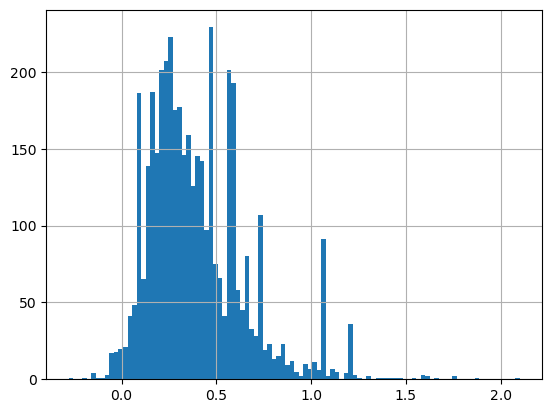

In [29]:
scaled_loss['max_scaled_loss'].hist(bins=100)
plt.show()

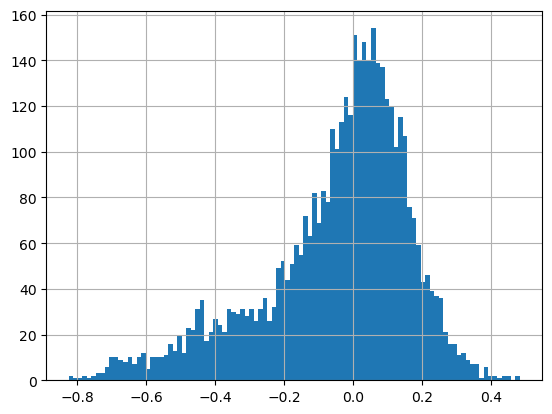

In [30]:
scaled_loss['row_scaled_loss'].hist(bins=100)
plt.show()

## as we can see - all "small" classes are NaN in scaled loss df

In [31]:
scaled_loss[scaled_loss.isna().any(axis=1)].sort_index()

,sex|scaled_loss,length|scaled_loss,diameter|scaled_loss,height|scaled_loss,whole_weight|scaled_loss,shucked_weight|scaled_loss,viscera_weight|scaled_loss,shell_weight|scaled_loss,rings|scaled_loss,diameter_bool|scaled_loss,rings_str|scaled_loss,max_scaled_loss,row_scaled_loss
232,-0.054047,0.438689,0.175888,-0.10565,-0.081535,0.323227,0.085142,-0.2213,-0.041287,-0.039945,NaN,0.438689,0.047869
236,-0.450617,-0.672944,-0.667316,-0.757511,-0.576464,-0.676149,-0.700981,-0.649998,1.881241,0.148030,NaN,1.881241,-0.432554
270,0.022125,0.282518,-0.156326,-0.213857,0.572195,0.541764,0.068379,-0.073765,-0.134458,-0.039945,NaN,0.572195,0.099814
275,0.053358,-0.012645,-0.231445,-0.275178,-0.197864,0.010332,-0.111102,-0.383109,0.490106,-0.050821,NaN,0.490106,-0.110527
294,-0.040629,0.167644,0.101004,0.07619,0.174731,0.168212,0.230555,0.217357,1.014524,0.215884,NaN,1.014524,0.294129
313,-0.222794,0.107187,0.282147,-0.02849,0.371243,0.336938,0.02588,0.325583,0.055454,0.262999,NaN,0.371243,0.186180
314,0.077372,0.139603,-0.009583,0.033905,0.07576,0.456895,0.05867,0.497725,0.823282,0.207633,NaN,0.823282,0.298902
351,0.046008,0.13059,0.088561,0.165464,-0.036857,0.097766,0.271911,0.263684,0.055454,0.000000,NaN,0.271911,0.128351
433,0.093332,0.084774,0.131719,0.091397,0.068379,0.000972,0.093255,0.040531,0.490106,0.000000,NaN,0.490106,0.129936
480,-0.055689,-0.35785,-0.409098,-0.050381,-0.20416,0.126869,0.090512,-0.116676,1.014524,-0.050821,NaN,1.014524,-0.017748


In [32]:
for c, data in small_classes.items():
    print(c)
    show_full_dataframe(data.sort_index())

rings_str


232     22
236      1
270     22
275     22
294     26
313     23
314     23
351     22
433     22
480     29
501     23
674     23
675     22
678     23
719      2
2108    27
2201    25
2209    27
2305    23
2334    23
2335    23
2436    23
3149    24
3280    24
Name: rings_str, dtype: object

### fill true_label with them

In [33]:
for c, data in small_classes.items():
    data_quality_df.loc[data.index, f'{c}|true_label'] = data

## now sort all data by anomaly score 
### which is number of NA and row score combination

In [34]:
anomaly_thresh = 1.5 # in std

In [35]:
scaled_loss['NA_count'] = scaled_loss.isna().sum(axis=1)
rare_class = scaled_loss['NA_count'] > 0
anomaly_value = scaled_loss['max_scaled_loss'] > anomaly_thresh
anomaly_combination = scaled_loss['row_scaled_loss'] > anomaly_thresh
scaled_loss['is_anomaly'] = rare_class | anomaly_value | anomaly_combination
# join with labels
labels = data_quality_df[[c for c in data_quality_df if any(s in c for s in ['true_label', 'pred_label'])]]
report = pd.concat([scaled_loss, labels], axis=1).reset_index().set_index(
    ['is_anomaly', 'NA_count', 'max_scaled_loss', 'row_scaled_loss', 'index']).sort_index(ascending=False)
report

sex|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                   
True       1         1.881241       -0.432554       236         -0.450617   
                     1.455653       -0.366114       719         -0.080281   
                     1.014524        0.324025       2201         0.022125   
                                     0.294129       294         -0.040629   
                                    -0.017748       480         -0.055689   
...                                                                   ...   
False      0        -0.148238       -0.752316       3902        -0.450617   
                    -0.155096       -0.564386       818         -0.461555   
                    -0.157663       -0.817119       1531        -0.676302   
                    -0.203910       -0.634967       2710         -0.20391   
                    -0.277824       -0.779707       1430        -0.296814   

                                                          length|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                      
True       1         1.881241       -0.432554       236            -0.672944   
                     1.455653       -0.366114       719            -0.680862   
                     1.014524        0.324025       2201            0.081471   
                                     0.294129       294             0.167644   
                                    -0.017748       480             -0.35785   
...                                                                      ...   
False      0        -0.148238       -0.752316       3902           -0.635449   
                    -0.155096       -0.564386       818             -0.60936   
                    -0.157663       -0.817119       1531           -0.701168   
                    -0.203910       -0.634967       2710           -0.675339   
                    -0.277824       -0.779707       1430           -0.689079   

                                                          diameter|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                        
True       1         1.881241       -0.432554       236              -0.667316   
                     1.455653       -0.366114       719              -0.662919   
                     1.014524        0.324025       2201               0.03124   
                                     0.294129       294               0.101004   
                                    -0.017748       480              -0.409098   
...                                                                        ...   
False      0        -0.148238       -0.752316       3902             -0.713199   
                    -0.155096       -0.564386       818              -0.358026   
                    -0.157663       -0.817119       1531             -0.676143   
                    -0.203910       -0.634967       2710             -0.512503   
                    -0.277824       -0.779707       1430             -0.676143   

                                                          height|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                      
True       1         1.881241       -0.432554       236            -0.757511   
                     1.455653       -0.366114       719            -0.691696   
                     1.014524        0.324025       2201            0.043086   
                                     0.294129       294              0.07619   
                                    -0.017748       480            -0.050381   
...                                                                      ...   
False      0        -0.148238       -0.752316       3902           -0.777702   
                    -0.155096       -0.564386       818            -0.241291   
                    -0.157663       -0.817119       1531           -0.833193   
                    -0.203910       -0.634967       2710           -

In [36]:
# take a look at all rows marked as anomaly
show_full_dataframe(report.loc[(True, slice(None), slice(None), slice(None), slice(None))])

sex|scaled_loss  \
NA_count max_scaled_loss row_scaled_loss index                   
1        1.881241        -0.432554       236         -0.450617   
         1.455653        -0.366114       719         -0.080281   
         1.014524         0.324025       2201         0.022125   
                          0.294129       294         -0.040629   
                         -0.017748       480         -0.055689   
         0.853121         0.448066       2209         0.048258   
         0.823282         0.298902       314          0.077372   
         0.683248         0.301959       678         -0.126289   
         0.610383        -0.067639       3149        -0.055689   
                         -0.177734       2108        -0.137836   
         0.572195         0.099814       270          0.022125   
         0.557223         0.160483       501          0.022125   
         0.504676         0.160717       2436        -0.017106   
         0.490106         0.129936       433          0.093332   
                         -0.110527       275          0.053358   
         0.478404        -0.033819       3280        -0.038122   
         0.438689         0.047869       232         -0.054047   
         0.399786        -0.004917       674         -0.160881   
         0.396560         0.189630       675         -0.031074   
         0.371243         0.186180       313         -0.222794   
         0.288756         0.163325       2335        -0.070664   
         0.271911         0.128351       351          0.046008   
         0.216190         0.056663       2305         0.011886   
         0.055454        -0.478913       2334         -0.11938   
0        2.101198         0.341043       90          -0.070943   
         1.764775         0.281224       2397         1.764775   
         1.757453         0.273202       1385         1.757453   
         1.659778         0.263447       1958         1.659778   
         1.618977         0.289781       2123         1.618977   
                         -0.150260       136          1.618977   
         1.598175         0.440696       1699         1.598175   
         1.596403         0.431900       2962         1.596403   
         1.581915        -0.042379       2117         1.581915   
         1.542587         0.020877       2641        -0.254037   

                                               length|scaled_loss  \
NA_count max_scaled_loss row_scaled_loss index                      
1        1.881241        -0.432554       236            -0.672944   
         1.455653        -0.366114       719            -0.680862   
         1.014524         0.324025       2201            0.081471   
                          0.294129       294             0.167644   
                         -0.017748       480             -0.35785   
         0.853121         0.448066       2209             0.51885   
         0.823282         0.298902       314             0.139603   
         0.683248         0.301959       678             0.683248   
         0.610383        -0.067639       3149           -0.201633   
                         -0.177734       2108            -0.23329   
         0.572195         0.099814       270             0.282518   
         0.557223         0.160483       501             0.431092   
         0.504676         0.160717       2436           -0.028493   
         0.490106         0.129936       433             0.084774   
                         -0.110527       275            -0.012645   
         0.478404        -0.033819       3280           -0.251049   
         0.438689         0.047869       232             0.438689   
         0.399786        -0.004917       674             0.123024   
         0.396560         0.189630       675             0.124292   
         0.371243         0.186180       313             0.107187   
         0.288756         0.163325       2335            0.082241   
         0.271911         0.128351       351              0.13059   
         0.216

In [37]:
# take a look at modified row
show_full_dataframe(report.loc[(slice(None), slice(None), slice(None), slice(None), list(range(90, 95)))])

sex|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                   
True       0        2.101198         0.341043       90          -0.070943   
False      0        0.193312         0.034827       91           0.066421   
                    0.651380         0.140899       92          -0.014133   
                    0.262999         0.053847       93           0.050979   
                    0.216729        -0.093478       94           0.013909   

                                                          length|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                      
True       0        2.101198         0.341043       90              0.366558   
False      0        0.193312         0.034827       91              0.062731   
                    0.651380         0.140899       92               0.07792   
                    0.262999         0.053847       93             -0.016389   
                    0.216729        -0.093478       94             -0.278182   

                                                          diameter|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                        
True       0        2.101198         0.341043       90                0.269887   
False      0        0.193312         0.034827       91                0.183994   
                    0.651380         0.140899       92                0.189254   
                    0.262999         0.053847       93               -0.178681   
                    0.216729        -0.093478       94               -0.148845   

                                                          height|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                      
True       0        2.101198         0.341043       90              0.334973   
False      0        0.193312         0.034827       91             -0.013874   
                    0.651380         0.140899       92              -0.03203   
                    0.262999         0.053847       93              0.073887   
                    0.216729        -0.093478       94             -0.167867   

                                                          whole_weight|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                            
True       0        2.101198         0.341043       90                    2.101198   
False      0        0.193312         0.034827       91                   -0.100966   
                    0.651380         0.140899       92                    0.003317   
                    0.262999         0.053847       93                    0.011143   
                    0.216729        -0.093478       94                   -0.244729   

                                                          shucked_weight|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                              
True       0        2.101198         0.341043       90                      0.513554   
False      0        0.193312         0.034827       91                     -0.015055   
                    0.651380         0.140899       92                      0.104803   
                    0.262999         0.053847       93                      0.042256   
                    0.216729        -0.093478       94                      0.216729   

                                                          viscera_weight|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                              
True       0        2.101198         0.341043       90                      0.453055   
False      0        0.193312         0.034827       91                      0.193312   
                    0.651380         0.140899       92                       0.00451   
                    0.262999         0.053847       93                      0.005661   
                    0.216729        -0.093478       94                   

# combine all together

In [38]:
def make_data_quality_report(
    input_path: str, output_path: str, ignore_columns: list = None,
    k_folds = 5, reg_quantiles = 20, anomaly_thresh=3.0,
):
    init_df = pd.read_parquet(input_path)
    if ignore_columns:
        init_df = init_df.drop(init_df, axis=1)
    regression_cols = init_df.select_dtypes(include=np.number).columns
    classification_cols = init_df.columns.difference(regression_cols)
    print(f'classification_cols: {classification_cols}')
    print(f'regression_cols: {regression_cols}')
    print('if column wrongly marked as regression - cast it to string type before saving to parquet')

    small_classes = {}
    data_quality = {}
    
    for c in init_df.columns:
        print(c)
        data_quality[c] = []
        # make a copy and ensure unique numeric index
        df = init_df.reset_index(drop=True)
        if c in regression_cols:
            # transform regression task to classification of quantile range
            df[c] = pd.qcut(df[c], reg_quantiles, duplicates='drop').astype(str)

        classes = df[c].value_counts().to_frame('counts')

        # rare labels (less than k_folds * 2 = 10 entries) automatically goes to outliers
        too_few_samples = classes[classes['counts'] < k_folds * 2]
        if too_few_samples.shape[0]:
            small_classes[c] = df.loc[df[c].isin(too_few_samples.index), c]
            df = df.drop(small_classes[c].index)
            classes = classes.drop(too_few_samples.index)

        if classes.shape[0] < 2: # constant value
            continue
        elif classes.shape[0] > 2: 
            multiclass = True
        else:
            multiclass = False

        loss = "MultiClass" if multiclass else "Logloss"
        params = {
            "verbose": False, 
            "od_wait": 5, 
            "use_best_model": True, 
            "auto_class_weights":'Balanced',
            "loss_function": loss,
            "eval_metric": 'TotalF1:average=Weighted'
        }
        # print(params)

        # for simplicity encode class labels to integers
        classes['label'] = list(range(classes.shape[0]))
        print(classes)
        labels = df[[c]].copy()
        labels['int_label'] = labels[c].apply(lambda x: classes.loc[x, 'label'])
        inv_classes = classes.reset_index().set_index('label')

        skf = StratifiedKFold(n_splits=k_folds, random_state=0, shuffle=True)
        for i, (train_index, val_test_index) in enumerate(skf.split(np.zeros(df.shape[0]), labels[c])):
            train_dataset = Pool(
                data=df.drop(c, axis='columns').iloc[train_index],
                label=labels['int_label'].iloc[train_index],
                cat_features=classification_cols.drop(c, errors='ignore').to_list()
            )
            # make validation and test from val_test_index
            skf2 = StratifiedKFold(n_splits=2, random_state=0, shuffle=True)
            test_val_splits_iterator = skf2.split(
                np.zeros(val_test_index.shape[0]), 
                labels[c].iloc[val_test_index]
            )
            for val_index, test_index in test_val_splits_iterator:
                val_dataset = Pool(
                    data=df.drop(c, axis='columns').iloc[val_test_index[val_index]],
                    label=labels['int_label'].iloc[val_test_index[val_index]],
                    cat_features=classification_cols.drop(c, errors='ignore').to_list()
                )
                test_dataset = Pool(
                    data=df.drop(c, axis='columns').iloc[val_test_index[test_index]],
                    label=labels['int_label'].iloc[val_test_index[test_index]],
                    cat_features=classification_cols.drop(c, errors='ignore').to_list()
                )
                clf = CatBoostClassifier(**params)
                clf.fit(train_dataset, eval_set=val_dataset)

                true_label = df[c].iloc[val_test_index[test_index]]
                pred_label = inv_classes.loc[np.array(clf.predict(test_dataset)).flatten(), 'index']
                cross_entropy = log_loss(
                    labels['int_label'].iloc[val_test_index[test_index]], 
                    clf.predict_proba(test_dataset)
                )
                preds = pd.DataFrame(
                    index=df.index[val_test_index[test_index]],
                    data=np.vstack((true_label, pred_label, cross_entropy)).T,
                    columns=['true_label', 'pred_label', 'cross_entropy']
                )
                data_quality[c].append(preds)
        data_quality[c] = pd.concat(data_quality[c])
    
    for c, cross_entropy in data_quality.items():
        scaled_loss, _, _ = scale_data(
            cross_entropy[['cross_entropy']], 
            test_df=None,
            quantile_range=(0,90)   # 90+ - highest loss values, small loss is OK, so left border is 0
        )
        cross_entropy['scaled_loss'] = scaled_loss['cross_entropy']
        cross_entropy.columns = [f'{c}|{dq_c}' for dq_c in cross_entropy.columns]
    data_quality_df = pd.concat(data_quality.values(), axis=1).sort_index()
    
    scaled_loss = data_quality_df[[c for c in data_quality_df.columns if 'scaled_loss' in c]].copy()
    
    row_scaled_loss, _, _ = scale_data(
        scaled_loss.mean(axis=1).to_frame('row_scaled_loss'), 
        test_df=None,
        quantile_range=(0,90)   # 90+ - highest loss values, small loss is OK, so left border is 0
    )
    scaled_loss['max_scaled_loss'] = scaled_loss.max(axis=1)
    scaled_loss['row_scaled_loss'] = row_scaled_loss['row_scaled_loss']
    
    for c, true_data in small_classes.items():
        data_quality_df.loc[true_data.index, f'{c}|true_label'] = true_data
    
    scaled_loss['NA_count'] = scaled_loss.isna().sum(axis=1)
    rare_class = scaled_loss['NA_count'] > 0
    anomaly_value = scaled_loss['max_scaled_loss'] > anomaly_thresh
    anomaly_combination = scaled_loss['row_scaled_loss'] > anomaly_thresh
    scaled_loss['is_anomaly'] = rare_class | anomaly_value | anomaly_combination
    # join with labels
    labels = data_quality_df[[c for c in data_quality_df if any(s in c for s in ['true_label', 'pred_label'])]]
    report = pd.concat([scaled_loss, labels], axis=1).reset_index().set_index(
        ['is_anomaly', 'NA_count', 'max_scaled_loss', 'row_scaled_loss', 'index']).sort_index(ascending=False)
    
    parquet_save(output_path, report)

In [39]:
report_path = PROCESSED_PATH / 'data_quality_report'

In [40]:
make_data_quality_report(abalone_path, report_path)

classification_cols: Index(['sex'], dtype='object')
regression_cols: Index(['length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
       'viscera_weight', 'shell_weight', 'rings'],
      dtype='object')
if column wrongly marked as regression - cast it to string type before saving to parquet
sex
   counts  label
M    1528      0
I    1342      1
F    1307      2
length
                counts  label
(0.625, 0.645]     269      0
(0.56, 0.575]      237      1
(0.525, 0.545]     232      2
(0.49, 0.51]       225      3
(0.585, 0.6]       224      4
(0.074, 0.295]     214      5
(0.295, 0.355]     214      6
(0.425, 0.45]      214      7
(0.39, 0.425]      213      8
(0.355, 0.39]      212      9
(0.545, 0.56]      210     10
(0.51, 0.525]      208     11
(0.69, 0.815]      207     12
(0.6, 0.615]       205     13
(0.47, 0.49]       202     14
(0.45, 0.47]       200     15
(0.615, 0.625]     181     16
(0.66, 0.69]       179     17
(0.645, 0.66]      175     18
(0.575, 0.585]   

sex|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                   
False      0        1.791471        0.426661        90          -0.009369   
                    1.639843        0.222023        2962         1.639843   
                    1.604759        0.340441        1812         0.035188   

                                                          length|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                      
False      0        1.791471        0.426661        90              0.096929   
                    1.639843        0.222023        2962            0.193272   
                    1.604759        0.340441        1812            0.139055   

                                                          diameter|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                        
False      0        1.791471        0.426661        90                0.434157   
                    1.639843        0.222023        2962              0.023621   
                    1.604759        0.340441        1812              0.305273   

                                                          height|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                      
False      0        1.791471        0.426661        90              0.146564   
                    1.639843        0.222023        2962            0.031265   
                    1.604759        0.340441        1812            0.037387   

                                                          whole_weight|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                            
False      0        1.791471        0.426661        90                    1.791471   
                    1.639843        0.222023        2962                  0.061723   
                    1.604759        0.340441        1812                  1.604759   

                                                          shucked_weight|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                              
False      0        1.791471        0.426661        90                      0.566309   
                    1.639843        0.222023        2962                   -0.002024   
                    1.604759        0.340441        1812                    0.201333   

                                                          viscera_weight|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                              
False      0        1.791471        0.426661        90                      0.450981   
                    1.639843        0.222023        2962                    0.048938   
                    1.604759        0.340441        1812                     0.06893   

                                                          shell_weight|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                            
False      0        1.791471        0.426661        90                    0.205307   
                    1.639843        0.222023        2962                 -0.100994   
                    1.604759        0.340441        1812                   0.50876   

                                                          rings|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                     
False      0        1.791471        0.426661        90            -0.131492   
                    1.639843        0.222023        2962           0.057436   
                    1.604759        0.340441        1812          -0.023016   

                                                          sex|true_label  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                  
False      0        1.791471        0.426661        90                 M   
                    1.639843        0.222023        2962               I   
               

tail(3):


sex|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                   
False      0        -0.620605       -0.854496       2169        -0.656489   
                    -0.625202       -0.852338       694         -0.671779   
                    -0.639721       -0.836832       2172        -0.656489   

                                                          length|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                      
False      0        -0.620605       -0.854496       2169           -0.620605   
                    -0.625202       -0.852338       694            -0.674285   
                    -0.639721       -0.836832       2172           -0.670989   

                                                          diameter|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                        
False      0        -0.620605       -0.854496       2169             -0.725594   
                    -0.625202       -0.852338       694              -0.707267   
                    -0.639721       -0.836832       2172             -0.707267   

                                                          height|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                      
False      0        -0.620605       -0.854496       2169           -0.751631   
                    -0.625202       -0.852338       694            -0.793502   
                    -0.639721       -0.836832       2172           -0.796547   

                                                          whole_weight|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                            
False      0        -0.620605       -0.854496       2169                  -0.68893   
                    -0.625202       -0.852338       694                  -0.625202   
                    -0.639721       -0.836832       2172                  -0.72418   

                                                          shucked_weight|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                              
False      0        -0.620605       -0.854496       2169                   -0.698605   
                    -0.625202       -0.852338       694                    -0.768774   
                    -0.639721       -0.836832       2172                   -0.639721   

                                                          viscera_weight|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                              
False      0        -0.620605       -0.854496       2169                   -0.667641   
                    -0.625202       -0.852338       694                    -0.749693   
                    -0.639721       -0.836832       2172                   -0.749693   

                                                          shell_weight|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                            
False      0        -0.620605       -0.854496       2169                 -0.743845   
                    -0.625202       -0.852338       694                  -0.762937   
                    -0.639721       -0.836832       2172                  -0.68351   

                                                          rings|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                     
False      0        -0.620605       -0.854496       2169           -0.89887   
                    -0.625202       -0.852338       694            -0.68192   
                    -0.639721       -0.836832       2172          -0.685896   

                                                          sex|true_label  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                  
False      0        -0.620605       -0.854496       2169               I   
                    -0.625202       -0.852338       694                I   
               

shape: (4177, 27)

saved data_quality_report to data\processed\data_quality_report\data_quality_report.parquet


In [41]:
# as we can see, changing this value does not have a dramatic effect on the gradient boosting model,
# however, the changed row is in the top 1 on the anomaly scale
# and it will be revealed when using a more rigid threshold value , for example 1.5

In [42]:
dt_end = datetime.utcnow()
print(dt_end)
print(f'total execution time: {dt_end - dt_start}')

2023-01-10 15:45:27.163924
total execution time: 0:05:41.248683
